https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/

In [81]:
def load_filtered_order_items(order_items_path, articles_path, bad_ids=None):
    import pandas as pd
    BAD = {"12025DK","12025FI","12025NO","12025SE","970300","459978"} if bad_ids is None else set(bad_ids)

    order_items = pd.read_parquet(order_items_path)
    articles = pd.read_parquet(articles_path)

    articles["groupId"] = articles["groupId"].astype(str).str.strip()
    order_items["groupId"] = order_items["groupId"].astype(str).str.strip()

    allowed_group_ids = set(articles["groupId"].dropna())
    n0 = len(order_items)

    order_items = (
        order_items
        .loc[~order_items["groupId"].isin(BAD)]
        .loc[order_items["groupId"].isin(allowed_group_ids)]
        .reset_index(drop=True)
    )

    print(f"Removed {n0 - len(order_items)} rows; {len(order_items)} remain.")
    return order_items


df = load_filtered_order_items(
    order_items_path="/workspace/data/processed/order_items.parquet",
    articles_path="/workspace/data/processed/articles_for_recs.parquet"
)


Removed 49400 rows; 262698 remain.


In [82]:
df = df[["order_id", "groupId"]]

In [83]:
def filter_group_ids_by_quantile(df, lower_q=0.5, upper_q=0.97):
    """
    Filter df to keep only groupIds whose frequencies are between the given quantiles (inclusive).
    Returns a new DataFrame along with quantiles used for filtering.
    """
    group_counts = df["groupId"].value_counts()
    lower_quantile = group_counts.quantile(lower_q)
    upper_quantile = group_counts.quantile(upper_q)
    group_ids_to_keep = group_counts[(group_counts >= lower_quantile) & (group_counts <= upper_quantile)].index
    return df[df["groupId"].isin(group_ids_to_keep)].reset_index(drop=True), lower_quantile, upper_quantile

df_before = df.copy()
df, lower_quantile, upper_quantile = filter_group_ids_by_quantile(df)
original_groupids = set(df_before["groupId"])
filtered_groupids = set(df["groupId"])
removed_groupids = original_groupids - filtered_groupids
print(f"Lower quantile (0.50): {lower_quantile}")
print(f"Upper quantile (0.97): {upper_quantile}")
print(f"GroupIds kept: {len(filtered_groupids)}, GroupIds removed: {len(removed_groupids)}")

Lower quantile (0.50): 19.0
Upper quantile (0.97): 1167.359999999997
GroupIds kept: 692, GroupIds removed: 771


In [86]:
# Group products by order_id so each row is an order, columns are product groupIds.
def create_basket(df):
    """
    Groups products by order_id, removes duplicates, and filters baskets with at least 2 items.
    Returns a DataFrame where each row is an order and groupId is a list of groupIds in that order.
    """
    basket = (
        df.groupby("order_id")["groupId"]
          .apply(lambda x: sorted(set(x)))  # remove duplicates
          .reset_index()
    )
    basket = basket[basket["groupId"].apply(lambda x: len(x) >= 2)]
    return basket

basket = create_basket(df)


In [87]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

def create_basket_df(basket):
    """
    Transforms a basket dataframe with a list of groupIds per order
    into a sparse boolean DataFrame (orders x groupIds).
    """
    mlb = MultiLabelBinarizer(sparse_output=True)
    X = mlb.fit_transform(basket["groupId"])
    basket_df = pd.DataFrame.sparse.from_spmatrix(
        X, index=basket["order_id"], columns=mlb.classes_
    ).astype(bool)
    return basket_df

basket_df = create_basket_df(basket)


In [88]:
basket_df.shape


(39594, 692)

In [70]:
from mlxtend.frequent_patterns import apriori

# For basket analysis, a 1% support threshold means itemsets must appear in at least 1% of orders.
# This is a common rule of thumb to capture meaningful but not overly rare item combinations.
# Adjust higher for smaller datasets, lower for larger. Here, let's use min_support=0.01.


def get_frequent_itemsets(basket_df, min_support=0.001):
    """Generate frequent itemsets using the apriori algorithm."""
    return apriori(
        basket_df,
        min_support=min_support, # an itemset must appear in ≥ 34 orders if dataset is 34163.
        use_colnames=True
    )

frequent_itemsets = get_frequent_itemsets(basket_df)

len(frequent_itemsets)

543

In [71]:
from mlxtend.frequent_patterns import association_rules

# For association rules, 'confidence' represents the probability that a product B is bought 
# when product A is bought. A common minimum confidence threshold is 0.1 to 0.2 for retail datasets,
# in order to filter out weak rules but still capture useful relationships.
# Here, we'll use min_confidence=0.15 as a balance between relevance and coverage.

#confidence ≈ 0.69 → when 261405 appears, 261426 is also in the basket ~69% of the time.

def build_rules(frequent_itemsets, min_confidence: float = 0.1):
    """Generate association rules filtered by confidence and sorted by lift."""
    return association_rules(
        frequent_itemsets, metric="confidence", min_threshold=min_confidence
    ).sort_values("lift", ascending=False)


rules = build_rules(frequent_itemsets)

print(
    f"Generated {len(rules)} association rules"
    f"and sorted by lift (higher lift = stronger association)."
)

rules.head()


Generated 115 association rulesand sorted by lift (higher lift = stronger association).


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
56,(270307),(270308),0.002450,0.002172,0.001919,0.783505,360.722129,1.0,0.001914,4.609015,0.999677,0.710280,0.783034,0.833613
55,(270308),(270307),0.002172,0.002450,0.001919,0.883721,360.722129,1.0,0.001914,8.578931,0.999399,0.710280,0.883435,0.833613
46,(261426),(261405),0.009976,0.004496,0.003132,0.313924,69.828701,1.0,0.003087,1.451012,0.995612,0.276169,0.310826,0.505277
47,(261405),(261426),0.004496,0.009976,0.003132,0.696629,69.828701,1.0,0.003087,3.263412,0.990131,0.276169,0.693572,0.505277
54,(265823),(266072),0.002399,0.007274,0.001061,0.442105,60.780263,1.0,0.001043,1.779415,0.985913,0.123167,0.438017,0.293969


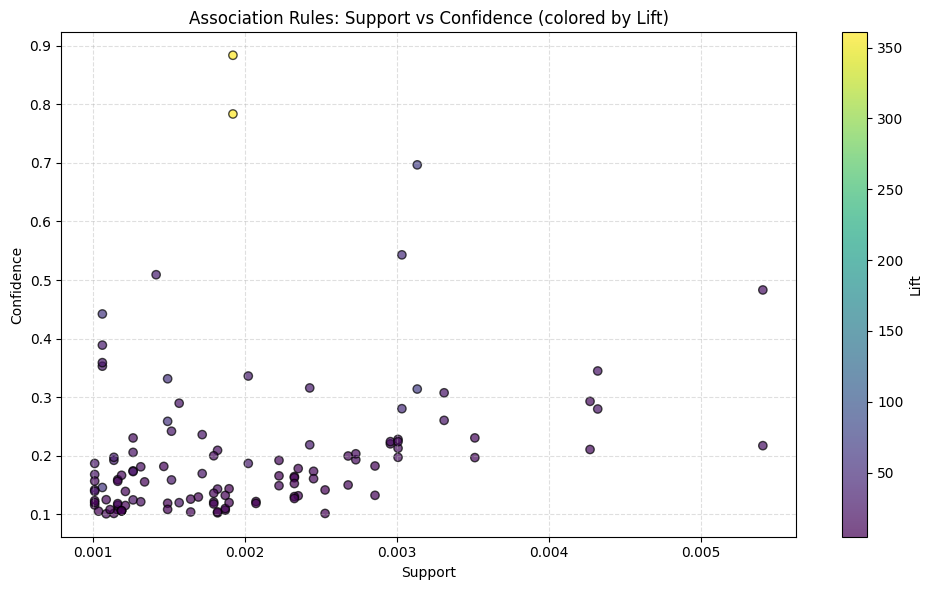

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    rules['support'], 
    rules['confidence'], 
    c=rules['lift'], 
    cmap='viridis', 
    alpha=0.7,
    edgecolor='k'
)

cbar = plt.colorbar(scatter)
cbar.set_label('Lift')

plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs Confidence (colored by Lift)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [73]:
import pandas as pd

def rules_to_parquet_topk(rules: pd.DataFrame, output_path: str, top_k: int = 10) -> pd.DataFrame:
    """Top-K consequents per antecedent using confidence; tie-break by lift; write Parquet."""
    r = rules[
        (rules["antecedents"].apply(lambda s: len(s) == 1)) &
        (rules["consequents"].apply(lambda s: len(s) == 1))
    ].copy()
    r["A"] = r["antecedents"].apply(lambda s: str(next(iter(s))))
    r["B"] = r["consequents"].apply(lambda s: str(next(iter(s))))
    r = r.sort_values(["A", "confidence", "lift"], ascending=[True, False, False]).groupby("A").head(top_k)

    def pack(g):
        pairs = list(zip(g["B"], g["confidence"]))[:top_k]
        pairs += [(None, None)] * (top_k - len(pairs))
        d = {"Product ID": g.name}
        for i, (cid, sc) in enumerate(pairs, 1):
            d[f"Top {i}"] = cid
            d[f"Score {i}"] = float(sc) if sc is not None else None
        return pd.Series(d)

    out = r.groupby("A").apply(pack, include_groups=False).reset_index(drop=True).sort_values("Product ID").reset_index(drop=True)
    out.to_parquet(output_path, index=False)
    return out




In [74]:
from pathlib import Path
import pandas as pd


# write Top-10 by confidence
out_path = Path("/workspace/data/processed/pair_complements.parquet")
out_df = rules_to_parquet_topk(rules, output_path=str(out_path))